In [39]:
import tensorflow as tf
import numpy as np
import json
import cv2
import os
import matplotlib.pyplot as plt

print(cv2.__version__ )

4.6.0


In [ ]:
# # Load a pretrained face recognition model (e.g., FaceNet)
# model = load_model('models/mobile_face_net.tflite')

# Initialize the TensorFlow Lite Interpreter for MobileFaceNet
interpreter = tf.lite.Interpreter(model_path='models/mobile_face_net.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load a pre-trained SSD model for face detection
ssd_model = tf.lite.Interpreter(model_path='models/lite-model_ssd_mobilenet_v2_100_fp32_default_1.tflite')
ssd_model.allocate_tensors()
ssd_input_details = ssd_model.get_input_details()
ssd_output_details = ssd_model.get_output_details()

# Folder containing multiple images of the same face
image_folder = 'input_images'

# An output file to store the extracted embeddings
output_file = 'embeddings/embeddings.json'

# A user name of the input images
user_name = 'Mussa'

# Create a list to store embeddings
all_embeddings = []

In [33]:
# Define a function to extract bounding boxes from SSD detection results
def extract_face_boxes(detection_results, image_shape, confidence_threshold=0.5):
    height, width = image_shape
    bounding_boxes = []
    for detection in detection_results[0]:
        confidence = detection[2]
        if confidence > confidence_threshold:
            left = int(detection[3] * width)
            top = int(detection[4] * height)
            right = int(detection[5] * width)
            bottom = int(detection[6] * height)
            bounding_boxes.append((left, top, right - left, bottom - top))
    return bounding_boxes

In [34]:
# Define a function to preprocess the input image
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Perform face detection with the "ssd_mobilenet_v2.tflite" model
    input_image = cv2.resize(image, (224, 224))  # Resize the image to match the model's input size
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    input_image = input_image.astype(np.float32)  # Convert to FLOAT32
    input_image /= 255.0  # Normalize pixel values to [0, 1]
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

    plt.imshow(cv2.cvtColor(cv2.cvtColor(input_image[0], cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    plt.title('Input image')
    plt.show()

    ssd_model.set_tensor(ssd_input_details[0]['index'], input_image)
    ssd_model.invoke()
    detection_results = ssd_model.get_tensor(ssd_output_details[0]['index'])
    
    # Extract bounding boxes of detected faces
    bounding_boxes = extract_face_boxes(detection_results, image.shape[:2])
    
    if not bounding_boxes:
        print(f"No faces detected in {image_path}")
        return None
    
    # Extract and preprocess each detected face
    face_images = []
    for (x, y, w, h) in bounding_boxes:
        face_image = image[y:y+h, x:x+w]  # Crop the detected face region
        
        # Preprocess the face image for the MobileFaceNet model
        face_image = cv2.resize(face_image, (112, 112))
        face_image = (face_image - 127.5) / 128.0  # Normalize pixel values to [-1, 1]
        face_image = np.float32(face_image)  # Convert to FLOAT32
        face_image = np.expand_dims(face_image, axis=0)  # Add batch dimension
        
        face_images.append(face_image)
    
    return face_images

In [35]:
# Define a function for face recognition
def recognize_faces(face_images):
    # Process each detected face
    for i, face_image in enumerate(face_images):
        # Perform inference with the MobileFaceNet model
        interpreter.set_tensor(input_details[0]['index'], face_image)
        interpreter.invoke()
        embeddings = interpreter.get_tensor(output_details[0]['index'])
        
        # Normalize the embeddings to have unit length
        embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
        
        # Display the preprocessed face image using Matplotlib
        # plt.imshow(face_image[0, :, :, 0], cmap='gray')  # Display in grayscale
        plt.imshow(cv2.cvtColor(cv2.cvtColor(face_image[0], cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Face {i+1}')
        plt.show()
        
        # You can further process or store the embeddings here
        # Example: Store embeddings in a list for later use
        all_embeddings.append(embeddings)

In [36]:
# List all image files in the folder
image_files = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.jpg')]

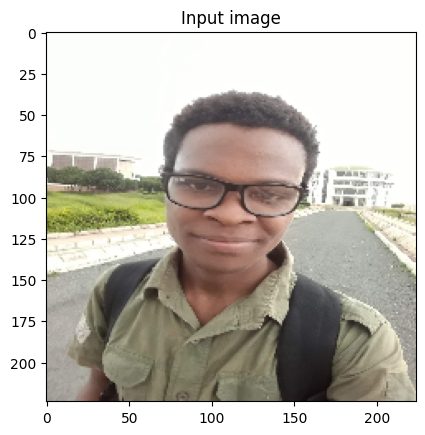

ValueError: Cannot set tensor: Dimension mismatch. Got 224 but expected 1 for dimension 1 of input 0.

In [37]:
# Iterate through the image files, detect faces, and recognize them
for image_path in image_files:
    face_images = preprocess_image(image_path)
    if face_images is not None:
        recognize_faces(face_images)

print(all_embeddings)

In [ ]:
# Calculate the average embedding (if needed)
if all_embeddings:

    # Calculate the average embedding
    average_embedding = np.mean(all_embeddings, axis=0)
    
    # Store the average embedding in a JSON file
    data = {
        'name': user_name,
        'embedding': average_embedding.tolist()
    }

    with open(output_file, 'w') as json_file:
        json.dump(data, json_file)
        print(data)

    print(f'Done creating embeddings for user: {user_name}')

else: 
    print("No embeddings generated for the input images")